# Figure 4

Plots for Devils each of the following simulations

- No intervention
- Vaccination
- Culling
- Natural Immunity

In [1]:
import os
import sys
sys.path.insert(1, os.path.abspath(os.path.join(os.getcwd(), '../GillesPy2')))

In [2]:
import numpy as np
import pickle

In [3]:
from gillespy2 import TauHybridCSolver

In [4]:
from dask.distributed import Client
from dask import delayed

In [5]:
sys.path.insert(2, os.path.abspath(os.path.join(os.getcwd(), './ParameterSweeps')))
from Devils_DFTD_2_Stage_Infection import DevilsDFTD2StageInfection
from Simulation import Simulation, devil_pop
from ParameterSweep import ParameterSweep

In [6]:
c = Client(n_workers=8, threads_per_worker=1)
# c = Client("james.cs.unca.edu:12345")

## Load Simulation data and Paramter Sweeps

In [7]:
base_path = "./ParameterSweeps"

with open(os.path.join(base_path, "DevilsDFTD2StageInfectionWithVaccinationState.p"), "rb") as vsf:
    vacc_job = ParameterSweep.load_state(pickle.load(vsf)['job'])
    
with open(os.path.join(base_path, "DevilsDFTD2StageInfectionWithCullingState.p"), "rb") as csf:
    cull_job = ParameterSweep.load_state(pickle.load(csf)['job'])
    
with open(os.path.join(base_path, "DevilsDFTD2StageInfectionWithImmunityState.p"), "rb") as isf:
    immun_job = ParameterSweep.load_state(pickle.load(isf)['job'])

## Run Simulation for No Interventions

In [8]:
model = DevilsDFTD2StageInfection(devil_pop)
model.timespan(np.arange(0, 1001, 1))

In [9]:
sim = Simulation(model)

In [10]:
sol = delayed(TauHybridCSolver)(model=model, variable=True)

In [11]:
sim.configure(solver=sol)
%time _ = sim.run(use_existing_results=True)

CPU times: user 1.1 s, sys: 300 ms, total: 1.4 s
Wall time: 21.1 s


## Plots for Figure 4

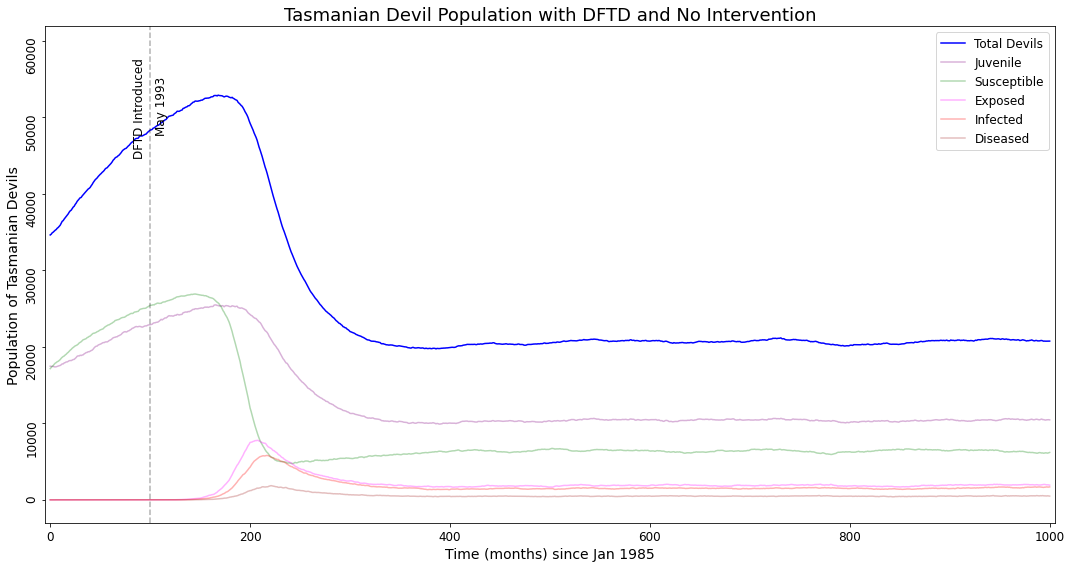

In [12]:
sim.plot()

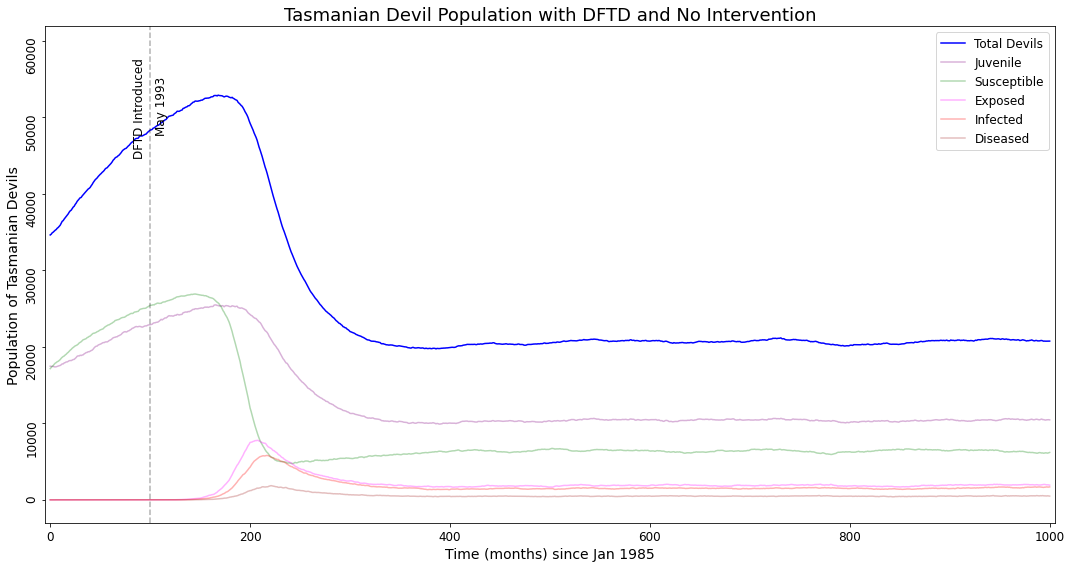

In [20]:
sim.plot(save_fig="DFTDmodel_sec4_no_intervention.pdf")

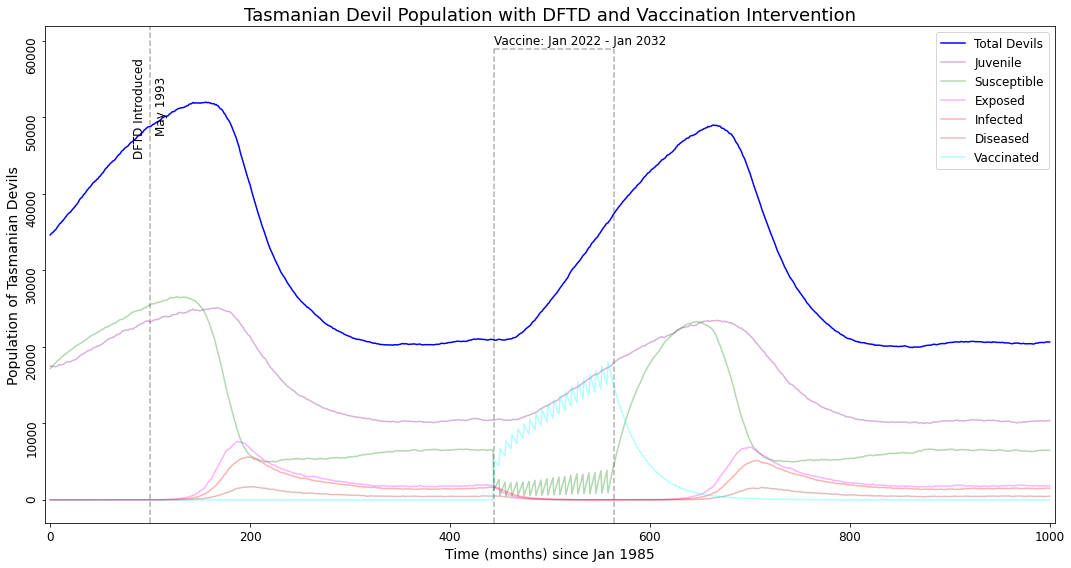

In [14]:
vacc_key = "vaccinated_infection_rate:0.6,vaccination_proportion:0.8,vacc_program_length:10,vaccine_frequency:2"
vacc_job.results[vacc_key].plot()

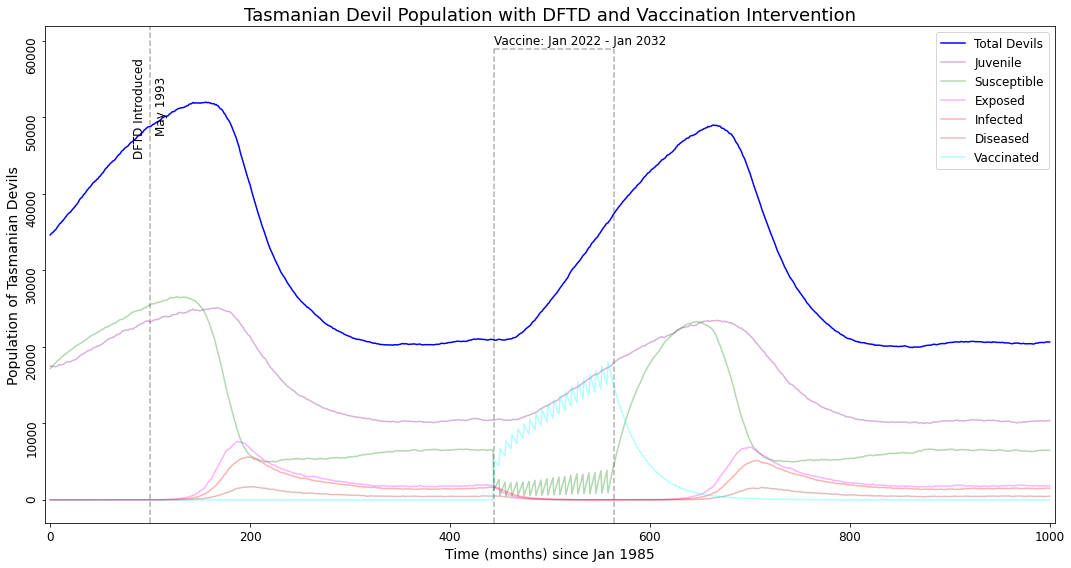

In [21]:
vacc_job.results[vacc_key].plot(save_fig="DFTDmodel_sec4_vaccination.pdf")

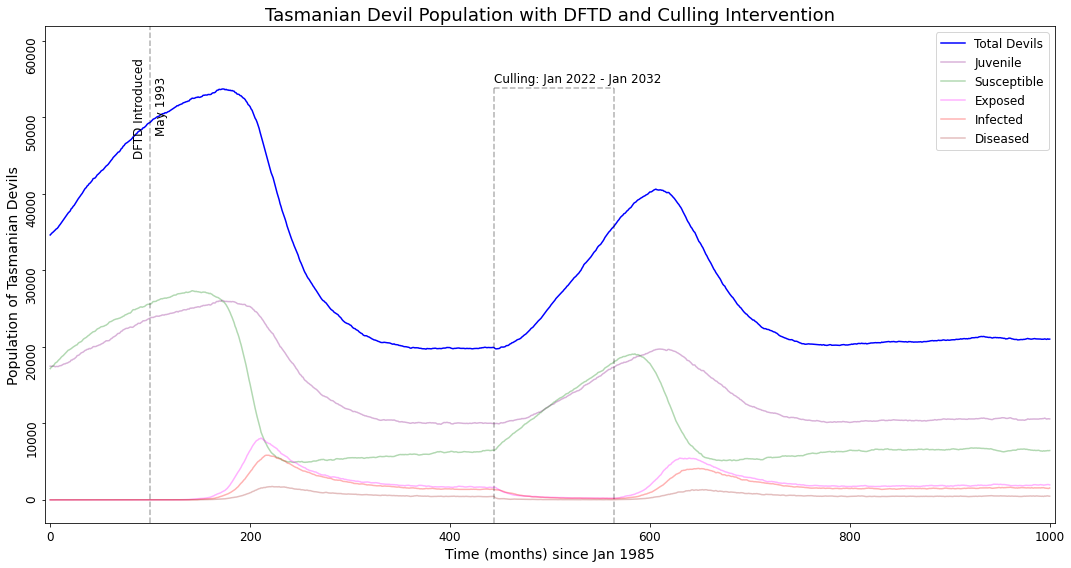

In [16]:
cull_key = "cull_rate_diseased:0.5,cull_program_length:10"
cull_job.results[cull_key].plot()

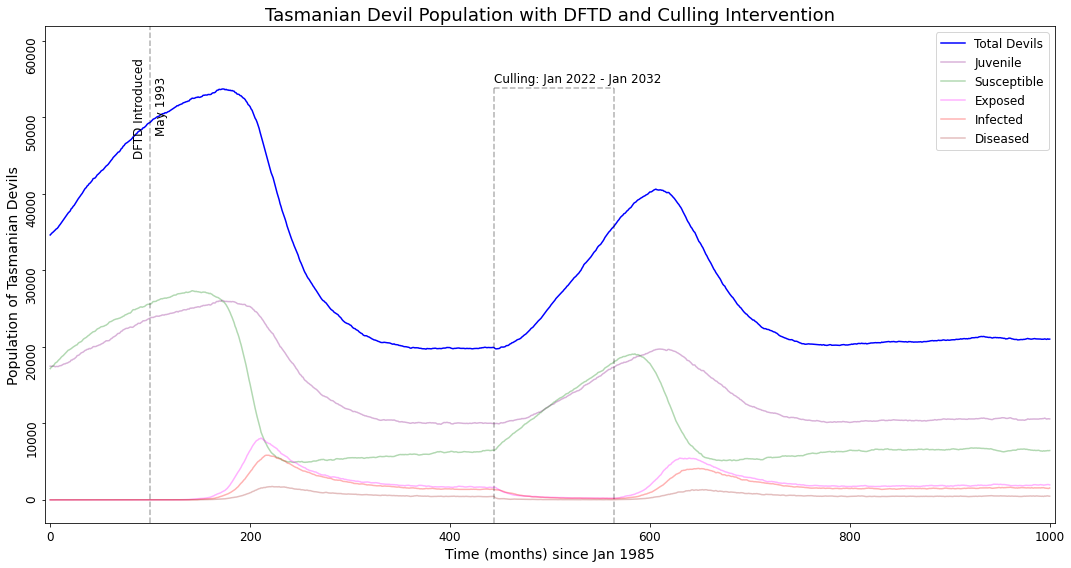

In [22]:
cull_job.results[cull_key].plot(save_fig="DFTDmodel_sec4_culling.pdf")

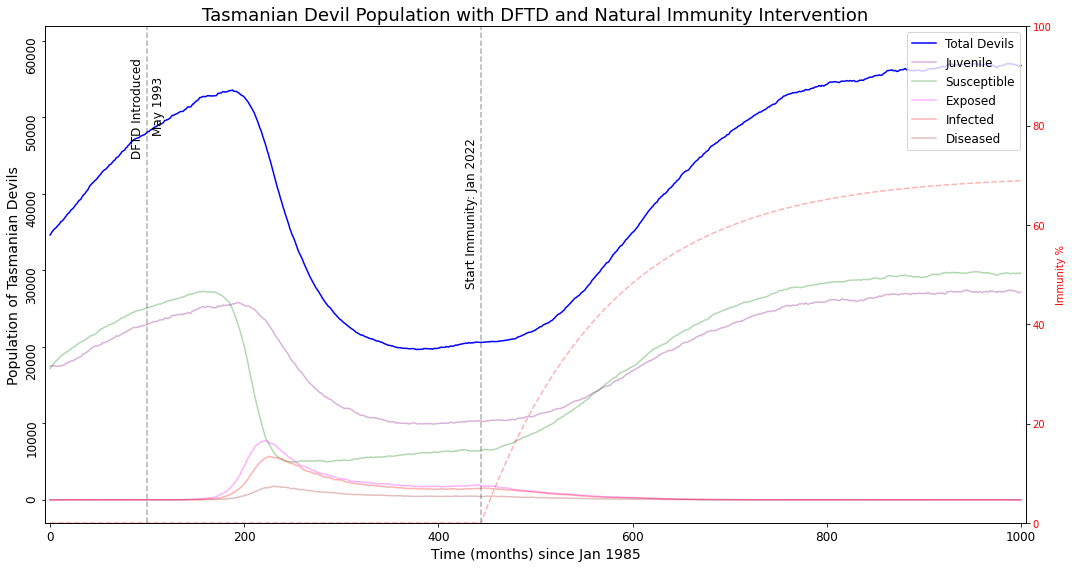

In [18]:
immun_key = "immunity_growth_rate:0.0075,immunity_max_level:70,immunity_start:444"
immun_job.results[immun_key].plot()

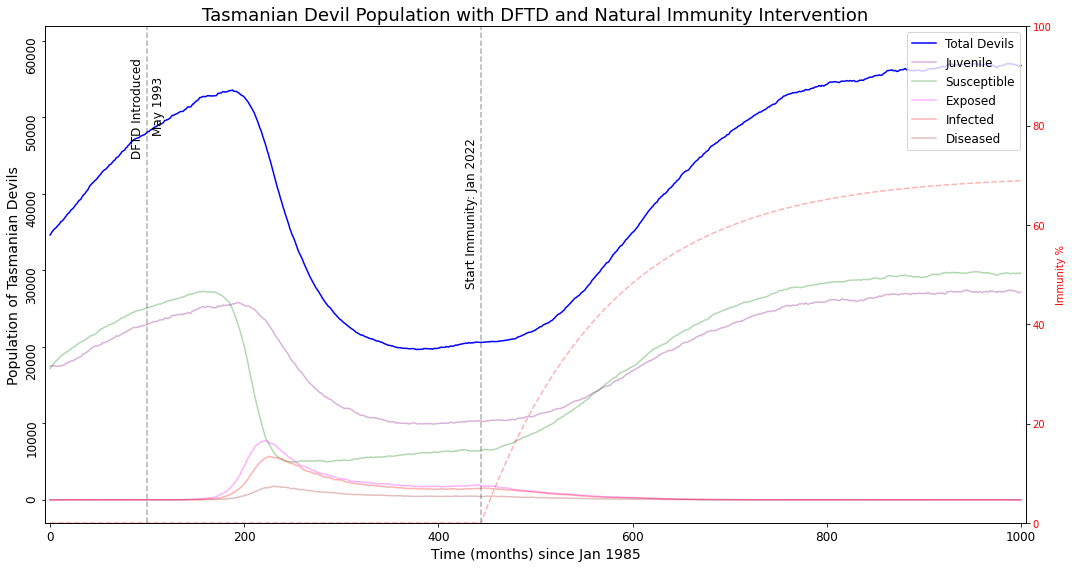

In [23]:
immun_job.results[immun_key].plot(save_fig="DFTDmodel_sec4_immunity.pdf")